In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from tqdm import tqdm

train_data_path = './data/train'
test_data_path = './data/test'

train_files = os.listdir(train_data_path)
test_files = os.listdir(test_data_path)

vitals_features = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']
lab_features = ['BaseExcess','HCO3','FiO2','pH','PaCO2','SaO2','AST','BUN','Alkalinephos','Calcium','Chloride','Creatinine','Bilirubin_direct','Glucose','Lactate','Magnesium','Phosphate','Potassium','Bilirubin_total','TroponinI','Hct','Hgb','PTT','WBC','Fibrinogen','Platelets']
demographic_features = ['Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']
target = 'SepsisLabel'

In [3]:
dynamic_features = vitals_features + lab_features
take_max_cols = ['SepsisLabel', 'Age', 'Gender', 'ICULOS']

def preprocessing(dfs: list[pd.DataFrame], interactions=True):
    patient_vecs = []
    with tqdm(total=len(dfs)) as pbar:
        for i in range(len(dfs)):
            _df = dfs[i]
            _mean = _df[dynamic_features].mean().add_suffix('_mean')
            _rolling_mean = _df[dynamic_features].rolling(3).mean().mean().add_suffix('_rolling_mean')
            _diff_mean = _df[dynamic_features].diff().mean().add_suffix('_diff_mean')
            _median = _df[dynamic_features].median().add_suffix('_median')
            _mean_minus_median = (_df[dynamic_features].mean() - _df[dynamic_features].median()).add_suffix('_mean_minus_median')
            _std = _df[dynamic_features].std().add_suffix('_std')
            _sem = _df[dynamic_features].sem().add_suffix('_sem')
            _range = (_df[dynamic_features].max() - _df[dynamic_features].min()).add_suffix('_range')
            _max1 = _df[vitals_features].max().add_suffix('_max')
            _max2 = _df[['SepsisLabel', 'Gender', 'Age', 'ICULOS']].max()
            _skew  = _df[dynamic_features].skew().add_suffix('_skew')
            _pvec = pd.concat([_mean, _rolling_mean, _diff_mean, _range, _std, _sem, _median, _mean_minus_median, _max1, _max2, _skew], axis=0)
            patient_vecs.append(_pvec)
            pbar.update(1)


    _df = pd.DataFrame(patient_vecs)
    _df.reset_index(drop=True, inplace=True)

    if interactions:
        for f1 in vitals_features:
            for f2 in vitals_features:
                if f1 != f2 and f1 + '_mean' in _df and f2 + '_mean' in _df:
                    f1_mean = _df[f1 + '_mean']
                    f2_mean = _df[f2 + '_mean']
                    _df[f'log_{f1}_mean_x_{f2}_mean'] = np.log(1+f1_mean) * np.log(1+f2_mean)
                    _df[f'{f1}_mean_over_{f2}_mean'] = f1_mean / (1+f2_mean)
                    _df[f'{f1}_skew_x_{f2}_skew'] = _df[f1+'_skew'] * _df[f2+'_skew']

    return _df

In [4]:
def read_dataframes(data_path:str) -> list[pd.DataFrame]:
    _dfs = []
    _files = os.listdir(data_path)
    with tqdm(total=len(_files)) as pbar:
        for f in _files:
            _dfs.append(pd.read_csv(os.path.join(data_path, f), sep='|'))
            pbar.update(1)
    print(f'Found {len(_dfs)} dataframes in {data_path}')
    return _dfs

### Load training data

In [5]:
train_dfs = read_dataframes(train_data_path)

100%|██████████| 20000/20000 [01:37<00:00, 205.82it/s]

Found 20000 dataframes in ./data/train


In [6]:
train_df = preprocessing(train_dfs)

100%|██████████| 20000/20000 [08:00<00:00, 41.65it/s]
/var/folders/wd/57_v9c5142x7mhyp18nb4bt80000gn/T/ipykernel_3353/1131820091.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  _df[f'log_{f1}_mean_x_{f2}_mean'] = np.log(1+f1_mean) * np.log(1+f2_mean)
/var/folders/wd/57_v9c5142x7mhyp18nb4bt80000gn/T/ipykernel_3353/1131820091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  _df[f'{f1}_mean_over_{f2}_mean'] = f1_mean / (1+f2_mean)
/var/folders/wd/57_v9c5142x7mhyp18nb4bt80000gn/T/ipykernel_3353/1131820091.py:36: Performance

In [7]:
missing_values = (train_df.isna().sum() / len(train_df)).sort_values()
threshold = 0.2
features = list(missing_values[missing_values <= threshold].index)
features.remove(target)
f'{len(features)} training features'

'235 training features'

In [8]:
test_dfs = read_dataframes(test_data_path)

100%|██████████| 10000/10000 [00:42<00:00, 234.50it/s]

Found 10000 dataframes in ./data/test


In [9]:
test_df = preprocessing(test_dfs)

100%|██████████| 10000/10000 [03:52<00:00, 42.96it/s]
/var/folders/wd/57_v9c5142x7mhyp18nb4bt80000gn/T/ipykernel_3353/1131820091.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  _df[f'log_{f1}_mean_x_{f2}_mean'] = np.log(1+f1_mean) * np.log(1+f2_mean)
/var/folders/wd/57_v9c5142x7mhyp18nb4bt80000gn/T/ipykernel_3353/1131820091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  _df[f'{f1}_mean_over_{f2}_mean'] = f1_mean / (1+f2_mean)
/var/folders/wd/57_v9c5142x7mhyp18nb4bt80000gn/T/ipykernel_3353/1131820091.py:36: Performance

In [105]:
alpha = 0.97
weights = alpha * train_df[target] + (1-alpha) * (1-train_df[target])
print('Weighted average of target values (0.5=balanced):')
sum(weights * train_df[target]) / sum(weights)

Weighted average of target values (0.5=balanced):


0.7111289570490228

# Imputation

In [106]:
missing_values = (train_df.isna().sum() / len(train_df)).sort_values()
threshold = 0.1
features = list(missing_values[missing_values <= threshold].index)
features.remove(target)
print(f'{len(features)} training features')

X_train, y_train = train_df[features].to_numpy(), train_df[target].to_numpy()
X_test, y_test = test_df[features].to_numpy(), test_df[target].to_numpy()

imputer = SimpleImputer()
imputer.fit(X_train, y_train)

X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

183 training features


# Adaboost Classification

In [122]:
model = AdaBoostClassifier(n_estimators=350)
model.fit(X_train, y_train, weights)

AdaBoostClassifier(n_estimators=350)

In [123]:
y_predict_train = model.predict_proba(X_train)[:,1:].squeeze()
y_predict_test = model.predict_proba(X_test)[:,1:].squeeze()

In [ ]:
# HOW TO PLOT IMPORTANT FEATURES??

In [124]:
y_predict_train_label = model.predict(X_train)
f1_score(train_df[target], y_predict_train_label)

0.49826989619377154

In [108]:
# SAVE MODEL TO FILE

# Test

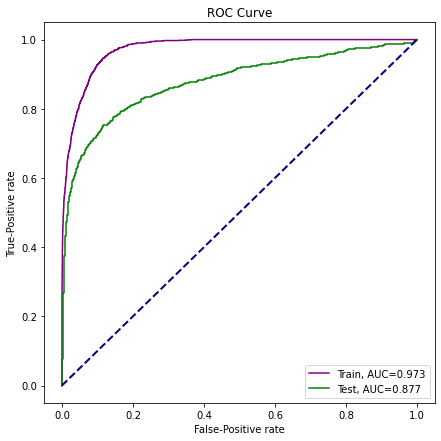

In [125]:
train_fpr, train_tpr, train_thresholds = roc_curve(y_true=train_df[target], y_score=y_predict_train)
test_fpr, test_tpr, test_thresholds = roc_curve(y_true=test_df[target], y_score=y_predict_test)

train_auc_score = roc_auc_score(y_true=train_df[target], y_score=y_predict_train)
test_auc_score = roc_auc_score(y_true=test_df[target], y_score=y_predict_test)

plt.figure(figsize=(7,7))
plt.title('ROC Curve')
plt.xlabel('False-Positive rate')
plt.ylabel('True-Positive rate')
plt.plot(train_fpr, train_tpr, color='purple', label='Train')
plt.plot(test_fpr, test_tpr, color='green', label='Test')
plt.legend([f'Train, AUC={train_auc_score:.3}', f'Test, AUC={test_auc_score:.3}'])
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.show()


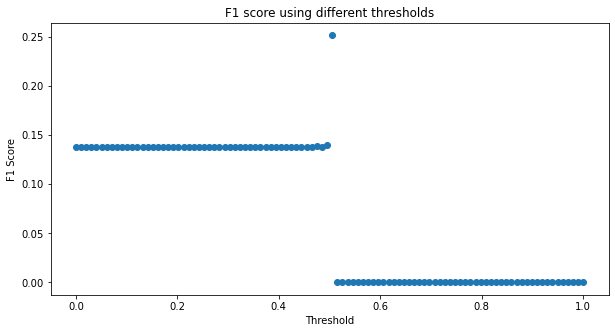

In [126]:
thresholds = np.linspace(0,1,100)
_f1 = [f1_score(y_true=test_df[target], y_pred=1*(y_predict_test >= t)) for t in thresholds]

plt.figure(figsize=(10,5))
plt.title('F1 score using different thresholds')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.scatter(thresholds, _f1)
plt.show()

In [127]:
max_f1 = max(_f1)
optimal_threshold = _f1.index(max_f1)
max_f1

0.2517162471395881

# Random Forest Classifiction

In [128]:
missing_values = (train_df.isna().sum() / len(train_df)).sort_values()
threshold = 0.2
features = list(missing_values[missing_values <= threshold].index)
features.remove(target)
print(f'{len(features)} training features')

X_train, y_train = train_df[features].to_numpy(), train_df[target].to_numpy()
X_test, y_test = test_df[features].to_numpy(), test_df[target].to_numpy()

imputer = SimpleImputer(strategy='median')
imputer.fit(X_train, y_train)

X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

alpha = 0.8
weights = alpha * train_df[target] + (1-alpha) * (1-train_df[target])
print('Weighted average of target values (0.5=balanced):')
sum(weights * train_df[target]) / sum(weights)

235 training features


In [130]:
forest = RandomForestClassifier(n_estimators=256, max_features=10)
print('Fitting...')
forest.fit(X_train, y_train, weights)

y_predict_train = forest.predict_proba(X_train)[:,1:].squeeze()
y_predict_test = forest.predict_proba(X_test)[:,1:].squeeze()
y_predict_train_label = forest.predict(X_train)
print('Train f1:', f1_score(train_df[target], y_predict_train_label))

thresholds = np.linspace(0,1,100)
_f1 = [f1_score(y_true=test_df[target], y_pred=1*(y_predict_test >= t)) for t in thresholds]
max_f1 = max(_f1)
optimal_threshold = thresholds[_f1.index(max_f1)]
print(f'max f1: {max_f1:.5}\nUsing threshold of {optimal_threshold:.4}')

RandomForestClassifier(max_features=10, n_estimators=256)

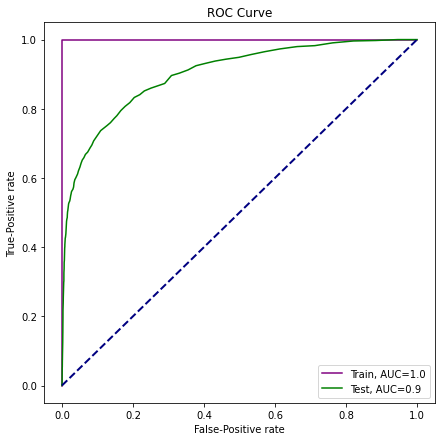

In [135]:
train_fpr, train_tpr, train_thresholds = roc_curve(y_true=train_df[target], y_score=y_predict_train)
test_fpr, test_tpr, test_thresholds = roc_curve(y_true=test_df[target], y_score=y_predict_test)

train_auc_score = roc_auc_score(y_true=train_df[target], y_score=y_predict_train)
test_auc_score = roc_auc_score(y_true=test_df[target], y_score=y_predict_test)

plt.figure(figsize=(7,7))
plt.title('ROC Curve')
plt.xlabel('False-Positive rate')
plt.ylabel('True-Positive rate')
plt.plot(train_fpr, train_tpr, color='purple', label='Train')
plt.plot(test_fpr, test_tpr, color='green', label='Test')
plt.legend([f'Train, AUC={train_auc_score:.3}', f'Test, AUC={test_auc_score:.3}'])
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.show()

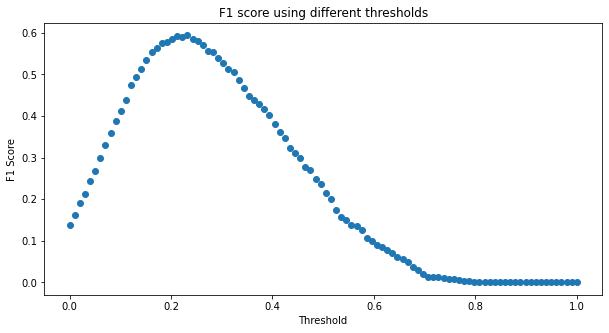

In [136]:
thresholds = np.linspace(0,1,100)
_f1 = [f1_score(y_true=test_df[target], y_pred=1*(y_predict_test >= t)) for t in thresholds]
max_f1 = max(_f1)
optimal_threshold = thresholds[_f1.index(max_f1)]
print(f'max f1: {max_f1:.5}\nUsing threshold of {optimal_threshold:.4}')
plt.figure(figsize=(10,5))
plt.title('F1 score using different thresholds')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.scatter(thresholds, _f1)
plt.show()